<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/raster_tools_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration to show how to download and use raster_tools surface module within Colab
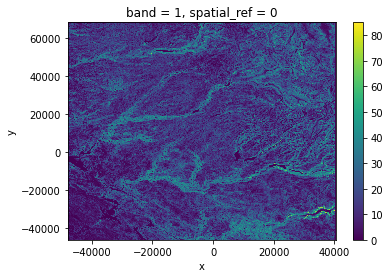

Author: John Hogland

# Use git to clone raster_tools to the local content directory

In [ ]:
!git clone https://github.com/UM-RMRS/raster_tools.git

fatal: destination path 'raster_tools' already exists and is not an empty directory.


# Install dependencies and raster_tools
Don't forget to restart the kernel after running the cell.

In [ ]:
!pip install rioxarray
!pip install dask_geopandas
!pip install dask_image
!pip install -e ./raster_tools

Obtaining file:///content/raster_tools
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for raster-tools


# Add raster_tools path to sys.path

In [ ]:
import sys
sys.path.append("/content/raster_tools")

# Import the tools and create a delayed reading raster surface (elevation). Look at how the data are chunked:

1.   small dataset (Stanislaus NF extent ~2.5 million acres @ 30m)
2.   one chunk

Note, the data could be chunked to take advantage of parallel processing (see notebook [rumple_index](https://colab.research.google.com/drive/1xfQM-aCjCR7JPj45ukXYv38xr4XJu5Wi?usp=sharing)).



In [ ]:
from raster_tools import Raster, surface
elev_path = "./raster_tools/test/data/elevation.tif"
elv=Raster(elev_path)
elv._rs

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<xarray.DataArray (band: 1, y: 3808, x: 2944)>
dask.array<copy, shape=(1, 3808, 2944), dtype=float32, chunksize=(1, 3808, 2944), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -4.604e+04 -4.601e+04 ... 6.814e+04 6.817e+04
  * band         (band) int64 1
  * x            (x) float64 -4.785e+04 -4.782e+04 ... 4.041e+04 4.044e+04
    spatial_ref  int64 0
Attributes:
    _FillValue:    -3.4028230607370965e+38
    scale_factor:  1.0
    add_offset:    0.0

# Convert the elevation raster surface to aspect, slope, curvature, northing, easting, hillshade, and 3d surface area raster datasets.
We could do far more including arithmetic, conditional, logical, focal, convolution, local, aggregation, distance etc. but will use common surface module functions for this example.

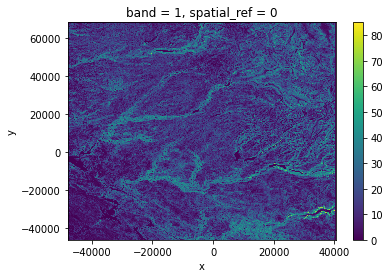

In [ ]:
asp=surface.aspect(elv)
sl=surface.slope(elv)
cur=surface.curvature(elv)
northing=surface.northing(elv)
easting=surface.easting(elv)
hillshade=surface.hillshade(elv)
s3d=surface.surface_area_3d(elv)

#use logical and arithmetic operations to change all cell values less than 0 to zero and plot results for slope raster (this could also be done with the remap function)
#note, nothing has been processed until ploting the results
((sl > 0) * sl)._rs.plot()


# Calculate the mean value of all cells greater than a value (cvl=0)
As one final example we will calculate means for surface raster cell values greater than a specified value (cvl=0) and cell counts for values less than that value.

In [ ]:
rslst=[asp,sl,cur,northing, easting, hillshade,s3d]
cvl=0 #compare value
for r in rslst:
  rxr=r.to_xarray()
  mv=rxr.where(rxr>=cvl).mean().values #conditional statement and mean calculation
  cnt=(rxr<cvl).sum().values #counts for the alternative
  print("Mean = " + str(mv) + ": < compare value count = " + str(cnt))


Mean = 191.09434423718204: < compare value count = 147714
Mean = 15.829436699392385: < compare value count = 13500
Mean = 0.7647183382281396: < compare value count = 5212429
Mean = 0.6430981669082128: < compare value count = 6010479
Mean = 0.6039692172177616: < compare value count = 6208412
Mean = 171.64166792736117: < compare value count = 0
Mean = 965.9186958966582: < compare value count = 13500


# Plot Aspect for values setting values less than zero equal to 0

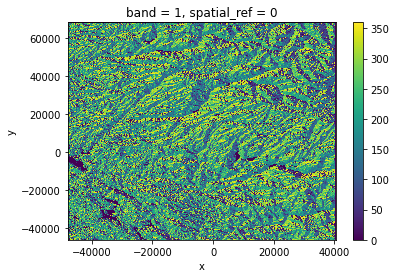

In [ ]:
((asp>=0)*asp)._rs.plot()

View the process chain of 3d surface area 

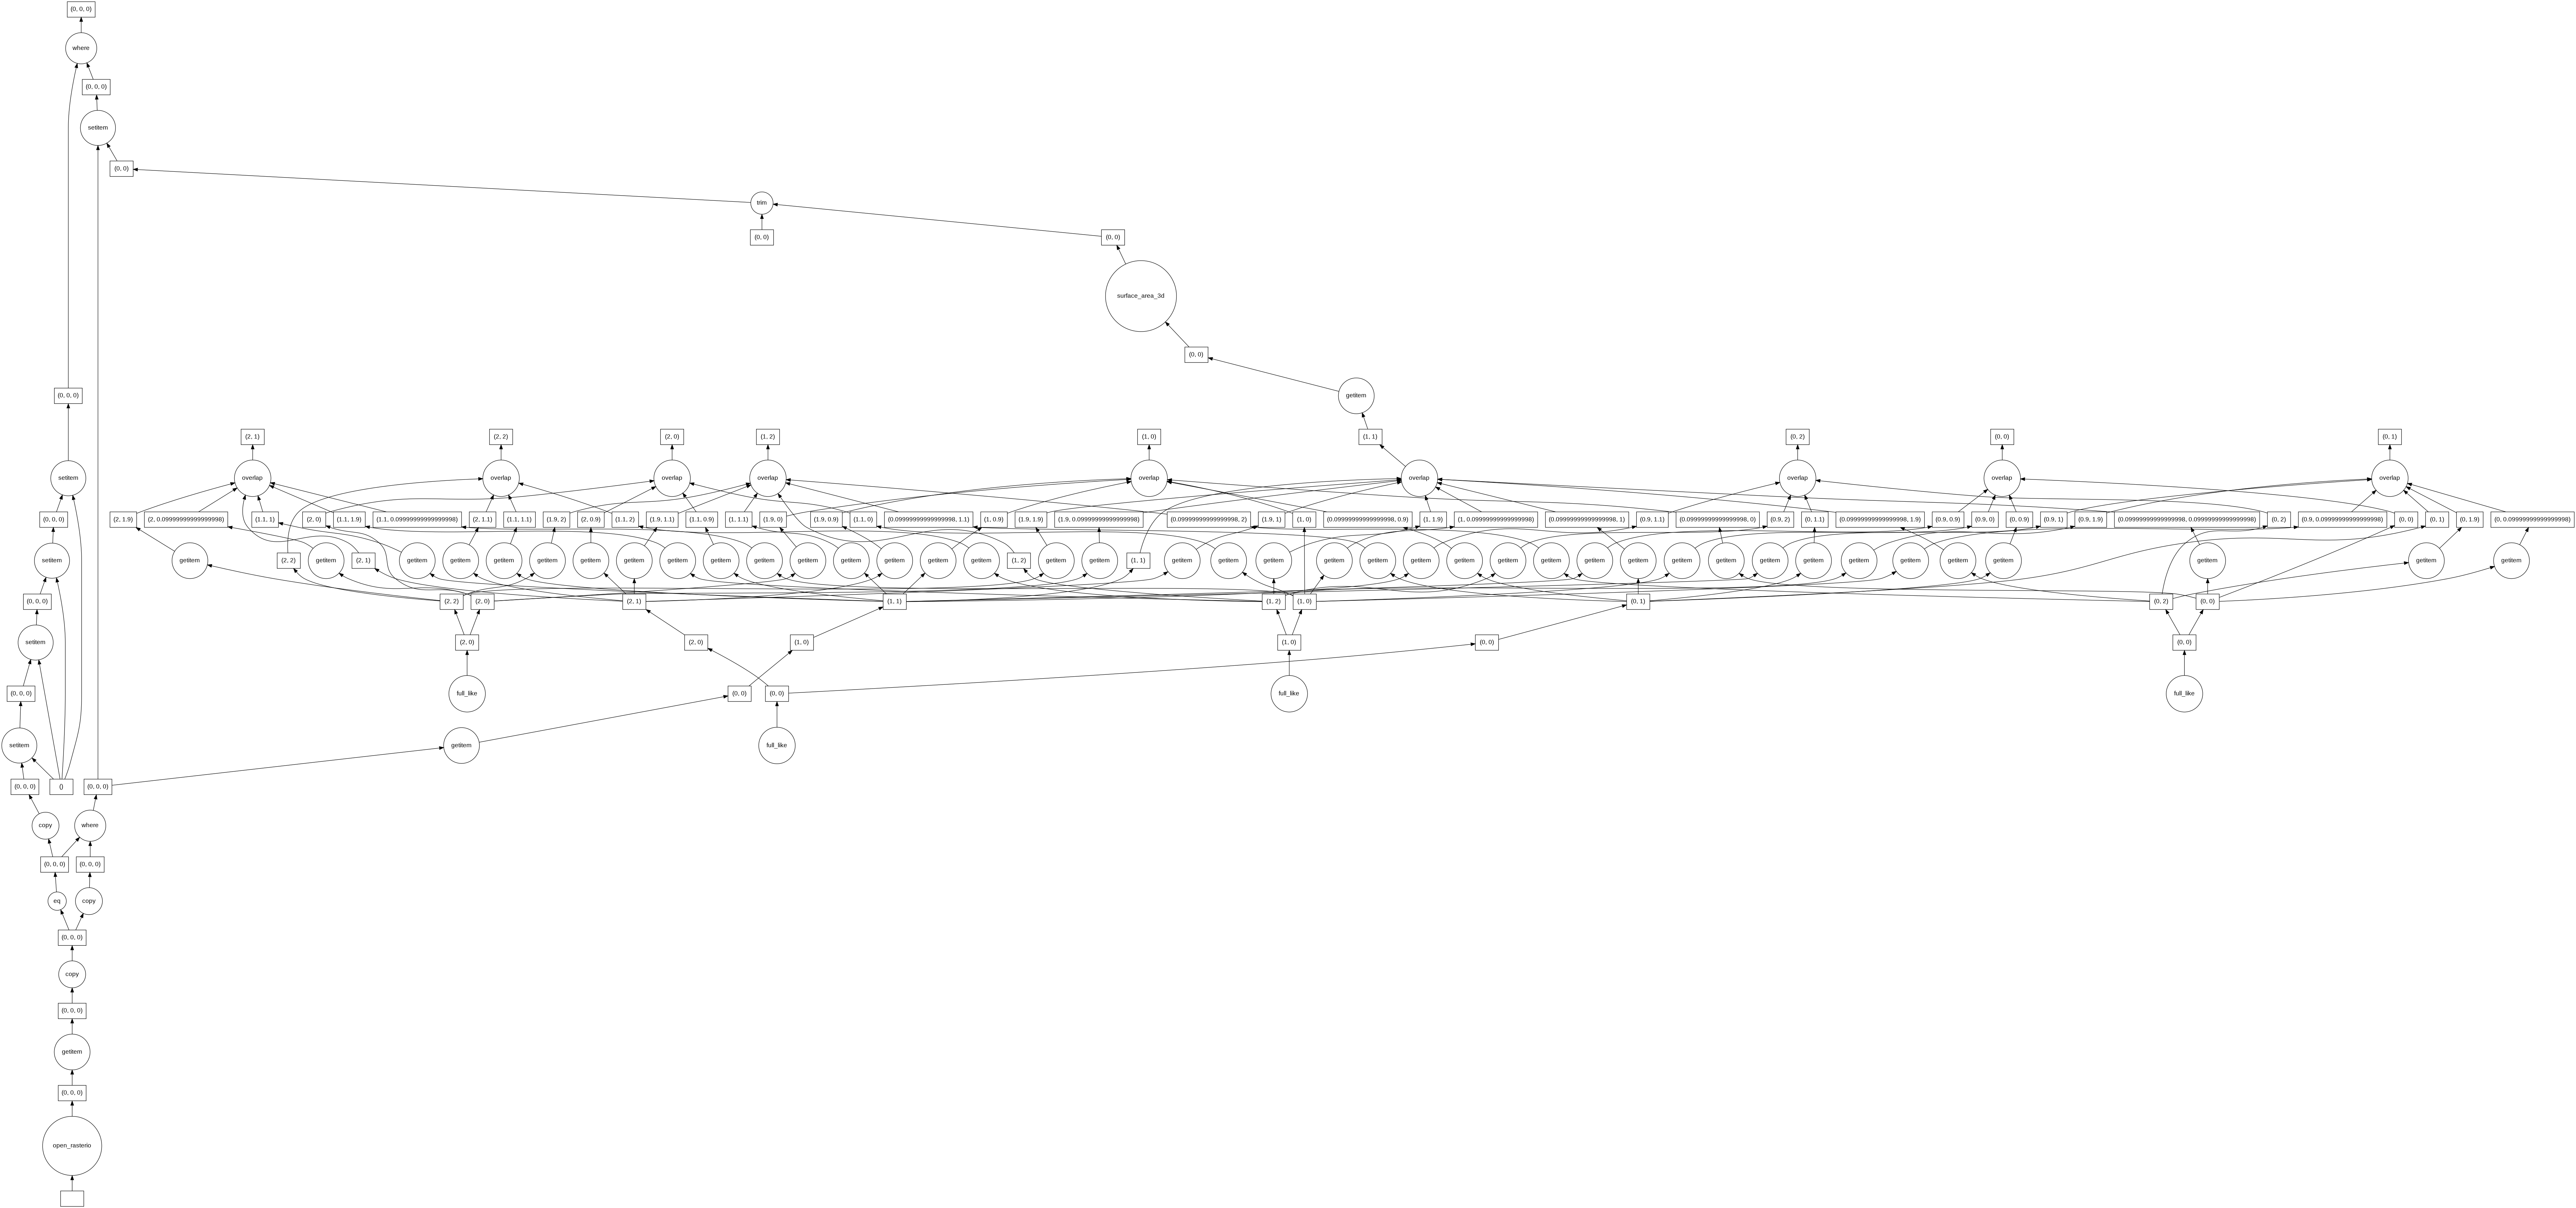

In [ ]:
s3d._rs.data.visualize()

# Visualize in Folium
we will use some raster math to normalize cell values between 0 and 1, reproject our raster to lat long, and then display the raster within folium with a streetmap backdrop. Note, all pixels are processed multiple time.

In [ ]:
from matplotlib import cm
import folium
from folium import plugins

#Step 1: Normalize the data and get color map
#address no data values for plotting
dxr = s3d._rs
s3d._rs.data = dxr.where(dxr != s3d.null_value) #masking no data
#getting normalization values
l=s3d._rs[0].min().values.item()
u=s3d._rs[0].max().values.item()
s3dn=(s3d-l)/(u-l)
cmap=cm.get_cmap('coolwarm')


#Step 2: reproject to lat lon
xds_utm = s3dn._rs.rio.reproject("epsg:4326") #we need to reproject our results to lat lon
w,s,e,n=xds_utm.rio.bounds() #get the bounds
bnd = [[s,w],[n,e]] #set the bound for folium
data=cmap(xds_utm[0])

#Step 3: build out the map
m=folium.Map()
folium.raster_layers.ImageOverlay(image=data,bounds=bnd,mercator_project=True,name='s3d').add_to(m) #add the raster
m.fit_bounds(bnd)
fs=plugins.Fullscreen()
m.add_child(fs)
folium.LayerControl().add_to(m) # add the layer control
m #view the map